In [1]:
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

### Functions for cancer cell simulation ###

# Determine the action of a cancerigenous cell

def action(P_dead, P_migra, P_repro):
    """
    Determine the action of a cancerigenous cell based on given probabilities.

    Parameters:
    P_dead (float): Probability of the cell dying.
    P_migra (float): Probability of the cell migrating.
    P_repro (float): Probability of the cell reproducing.

    Returns:
    str: The action taken by the cell ("dead", "migrate", "reproduce", or "stay").
    """

    r = random.random() # Generate a random number between 0 and 1
    #print(f"Random number: {r}")
    if r < P_dead:
        return "dead"
    elif r < P_dead + P_migra:
        return "migrate"
    elif r < P_dead + P_migra + P_repro:
        return "reproduce"
    else: # r >= P_dead + P_migra + P_repro
        return "stay"
    
# Select a random cell position

def select_cell(cell_list):
    """
    Select a random position from a list of cell positions.
    Parameters:
    free_n (list): List of tuples representing the coordinates of free neighboring positions.
    Returns:
    tuple or None: A tuple representing the coordinates of the selected position, or None if the
    list is empty.
    """
    N_L = len(cell_list)
    if N_L == 0:
        return None
    else:
        idx = random.randint(0, N_L)  # Select a random index
        return cell_list[idx]  # Return the position at the selected index
    
# Get free neighboring positions

def get_neighbors(grid, x, y, n):
    """ 
    Get a list of neighboring positions around a given cell in the grid, with a specific n state.
    Parameters: 
    grid (list of list): The grid representing the environment.
    x (int): The x-coordinate of the cell.
    y (int): The y-coordinate of the cell.
    n (int): The state representing a free cell (e.g., 0 for healthy).
    Returns:
    list: A list of tuples representing the coordinates of free neighboring positions.
    """

    rows = len(grid)
    cols = len(grid[0])
    free_neighbors = []

    for dx in [-1, 0, 1]:               ### Check all neighboring positions
        for dy in [-1, 0, 1]:           ### including diagonals
            if dx == 0 and dy == 0:     ## Skip the current cell itself
                continue 

            nx, ny = x + dx, y + dy     ## Calculate neighbor coordinates
            if 0 <= nx < rows and 0 <= ny < cols:     ## Check if within grid bounds
                if grid[nx][ny] == n:   ## Check if the neighbor cell is free (state 0)
                    free_neighbors.append((nx, ny))       ## Add free neighbor to the list

    return free_neighbors


def adjusted_probability(P_base, N_L, alpha):
    """
    Adjust the base probabilities of cell actions based on the availability of free neighboring positions.
    Parameters:
    P_base (dict): Dictionary containing base probabilities for 'dead', 'migrate', 'reproduce', and 'stay'.
    N_L (int): Number of free neighboring positions.
    alpha (float): Fraction of blocked action probability to be added to 'dead' action.
    Returns:
    dict: Adjusted probabilities for cell actions.
    """
    P_adjust = P_base.copy()

    if N_L > 0:
        return P_adjust
    
    P_bloq = P_base['migrate'] + P_base['reproduce']

    P_adjust['migrate'] = 0
    P_adjust['reproduce'] = 0
    P_adjust['dead'] = P_adjust['dead'] + alpha * P_bloq
    P_adjust['stay'] = P_adjust['stay'] + (1 - alpha) * P_bloq

    return P_adjust


def evolve_necrotic_cell(grid, x, y, P_clean, P_damage, P_necro_dead, active_cell_set):
    """
    Evolve the state of a necrotic cell based on given probabilities.
    Parameters:
    grid (list of list): The grid representing the environment.
    x (int): The x-coordinate of the necrotic cell.
    y (int): The y-coordinate of the necrotic cell.
    P_clean (float): Probability of the necrotic cell being cleaned.
    P_damage (float): Probability of the necrotic cell damaging neighboring cells.
    P_necro_dead (float): Probability of a neighboring cell becoming necrotic or dead.
    Returns:
    list of list: The updated grid after evolving the necrotic cell.

    """

    r = random.random()

    if r < P_clean:
        grid[x][y] = 0
        active_cell_set.remove((x, y))
        return grid
    

    if r < P_damage + P_clean:
        cancer_neighbors = get_neighbors(grid, x, y, 1)
        for (nx, ny) in cancer_neighbors:
            if random.random() < P_necro_dead:
                grid[nx][ny] = 2

    return grid    


def intialize_grid(rows, cols):
    """
    Initialize the grid with given dimensions and place a single cancer cell in the center.
    Parameters:
    rows (int): Number of rows in the grid.
    cols (int): Number of columns in the grid.
    Returns:
    list of list: The initialized grid.
    """
    grid = [[0 for _ in range(cols)] for _ in range(rows)]
    center_x, center_y = rows // 2, cols // 2
    grid[center_x][center_y] = 1
    return grid


def plot_grid(grid, title="Simulación de Células", t_step=None):
    """
    Generates a color-coded plot of the grid representing cell states.
    Parameters:
    grid (list of list): The grid representing the environment.
    title (str): Title of the plot.
    t_step (int, optional): Time step to display in the title. Defaults to None
    Returns:
    None
    """
    
    # 1. Convert the grid to a NumPy array 
    # Numpy will help in handling the grid data for plotting, because it provides efficient array operations and is compatible with matplotlib.
    import numpy as np
    grid_np = np.array(grid)

    # 2. Define the color map
    cmap = mcolors.ListedColormap(['white', 'red', 'black']) # Colors for healthy, cancerous, and necrotic cells
    bounds = [0, 1, 2, 3] # Limits for the colors
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # 3. Create the plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # 4. Display the grid
    im = ax.imshow(grid_np, cmap=cmap, norm=norm, origin='upper', 
                   interpolation='nearest')   ## Use 'nearest' to avoid interpolation between cells, which keeps the cell colors distinct.

    # 5. Set up grid lines
    ax.set_xticks(np.arange(-0.5, grid_np.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, grid_np.shape[0], 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.set_xticks([])
    ax.set_yticks([])

    # 6. Add color bar
    cbar = plt.colorbar(im, ax=ax, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0.5, 1.5, 2.5], pad=0.02)
    cbar.set_ticklabels(['Sana (0)', 'Cancerosa (1)', 'NecróTica (2)'])

    # 7. Set title
    if t_step is not None:
        ax.set_title(f"{title} (Paso de Tiempo Final: {t_step})")
    else:
        ax.set_title(title)

    # 8. Show the plot
    plt.show()


def plot_metrics_vs_time(data_list, time_steps, title, ylabel):
    """
    Plots a line graph of a given metric over time steps.
    Parameters:
    data_list (list): List of metric values to plot.
    time_steps (list): List of time steps corresponding to the metric values.
    title (str): Title of the graph.
    ylabel (str): Label for the Y-axis.
    Returns:
    None
    """
    
    plt.figure(figsize=(10, 6)) 
    
    
    plt.plot(time_steps, data_list, marker='o', linestyle='-', markersize=4)
    
   
    plt.title(title)
    plt.xlabel("Paso de Tiempo (t)")
    plt.ylabel(ylabel)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    
    if time_steps: 
        plt.xlim(0, time_steps[-1])
        
    plt.show()


def calculate_derivative(data_list, time_list):
    """
    Calculate the rate of change (derivative) of data_list with respect to time_list.
    Parameters:
    data_list (list): List of data points (e.g., number of cells).
    time_list (list): List of corresponding time points.
    Returns:
    list: List of rates of change between consecutive data points.
    """
    rates = []
    # Start from the second data point to calculate differences
    for i in range(1, len(data_list)):
        delta_y = data_list[i] - data_list[i-1]    # Change in data
        
        delta_x = time_list[i] - time_list[i-1]      # Change in time
        
        if delta_x == 0: # Avoid division by zero
            rate = 0
        else:
            rate = delta_y / delta_x
            
        rates.append(rate)
        
    return rates







                            




    

    

Simulación terminada. Generando imagen final...


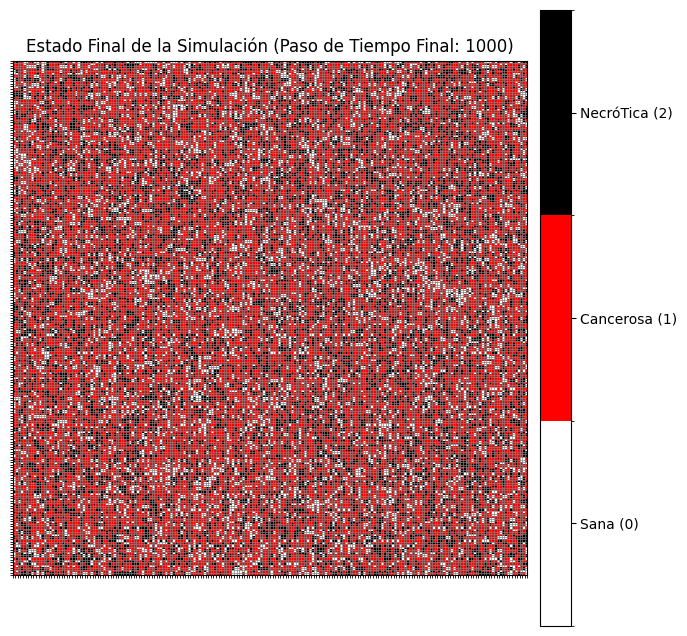

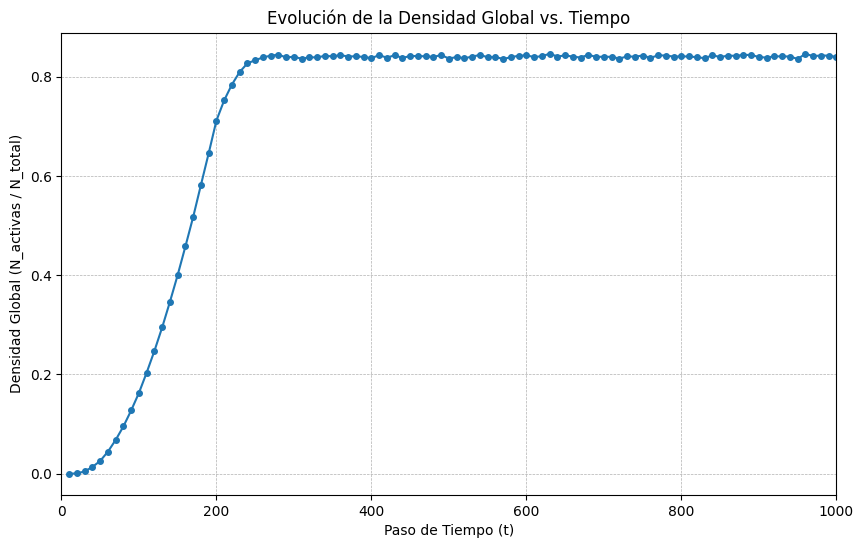

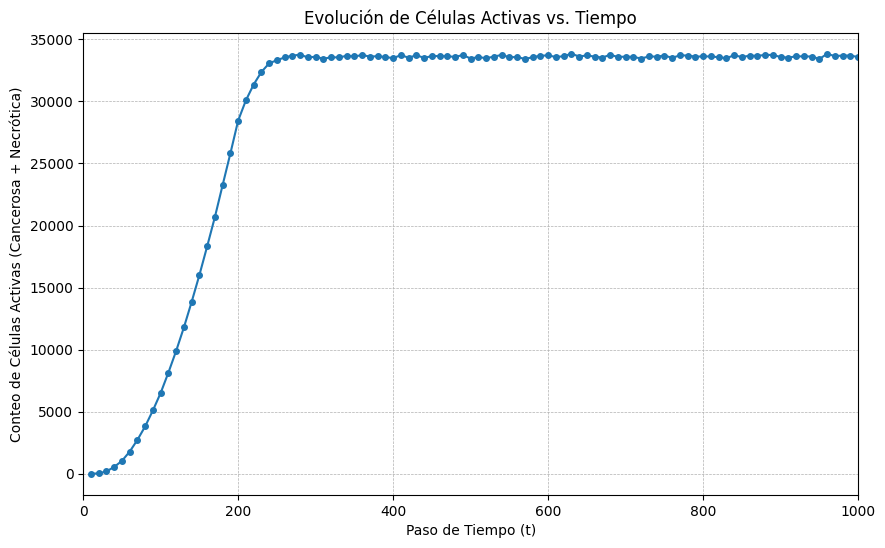

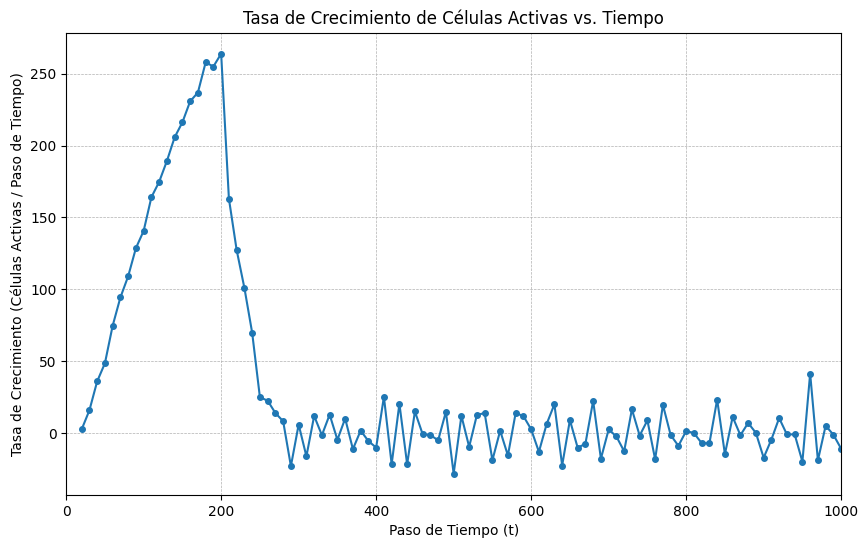

In [4]:
ROWS = 200
COLS = 200
Time_Units = 1000

P_base = {
    'dead': 0.1,
    'migrate': 0.4,
    'reproduce': 0.4,
    'stay': 0.1
}

alpha = 0.5

plot = False

RESISTANCE_SCORE = 0.2

P_clean = 0.5
P_damage = 0.05
P_necro_dead = 0.1

grid = intialize_grid(ROWS, COLS)

active_cell_set = {(ROWS // 2, COLS // 2)} ## Initial active cell is the center cancer cell
total_cells_in_grid = ROWS * COLS

densidad_global = []
celulas_activas = []
time_step_list = []
plot_interval = 10

for t in range(Time_Units):

    N_active = len(active_cell_set)    ## Number of active cells (cancerous + necrotic)
    if N_active == 0:                  ## If no active cells remain, end the simulation
        print("All cells have died.")
        break

    global_density = N_active / total_cells_in_grid   ## Global density of active cells

    alpha_t = (1 - RESISTANCE_SCORE) * global_density   ## Time-dependent alpha based on global density and resistance score

    active_cell_list = list(active_cell_set)         ## Convert set to list for random access

    for _ in range(N_active):

        select_coords = select_cell(active_cell_list)      ## Select a random active cell

        if select_coords is None:                 ## If there are no active cells, skip
            continue

        if select_coords not in active_cell_set: ## If the cell has already changed state, skip it
            continue

        x, y = select_coords                    ## Get coordinates

        cell_state = grid[x][y]               ## Get the state of the selected cell

        if cell_state == 1:  # Cancer cell

            ## Get free neighbors
            free_neighbors = get_neighbors(grid, x, y, 0)
            N_L = len(free_neighbors)

            ## Adjust probabilities
            P_adjust = adjusted_probability(P_base, N_L, alpha_t)

            ## Determine action
            act = action(P_adjust['dead'], P_adjust['migrate'], P_adjust['reproduce'])

            if act == "dead":
                if N_L: ## If there are free neighbors
                    grid[x][y] = 0  # Dies and becomes free
                    active_cell_set.remove((x, y))
                else: ## No free neighbors
                    grid[x][y] = 2  # Becomes necrotic

            elif act == "migrate":
                dest = select_cell(free_neighbors)
                if dest:
                    grid[dest[0]][dest[1]] = 1  # Move to new position
                    active_cell_set.add(dest)
                    grid[x][y] = 0  # Original position becomes free
                    active_cell_set.remove((x, y))

            elif act == "reproduce":
                dest = select_cell(free_neighbors)
                if dest:
                    grid[dest[0]][dest[1]] = 1  # New cancer cell at the destination
                    active_cell_set.add(dest)
            # If action is "stay", do nothing

        elif cell_state == 2:  # Necrotic cell
            grid = evolve_necrotic_cell(grid, x, y, P_clean, P_damage, P_necro_dead, active_cell_set)

    ## Plotting and data collection at intervals       
    if (t + 1) % plot_interval == 0 or (t + 1) == Time_Units:
        if plot == True:
            print(f"Generando imagen en el paso de tiempo: {t + 1}")
            print(f"Células activas: {len(active_cell_set)}")
            print(f"Densidad global: {len(active_cell_set) / total_cells_in_grid:.4f}")
            plot_grid(grid, title="Evolución del Tumor", t_step=t + 1)
    ### Data collection for metrics
        time_step_list.append(t + 1)
        densidad_global.append(len(active_cell_set) / total_cells_in_grid)
        celulas_activas.append(len(active_cell_set))




print("Simulación terminada. Generando imagen final...")
plot_grid(grid, title="Estado Final de la Simulación", t_step=Time_Units)

plot_metrics_vs_time(densidad_global, 
                     time_step_list, 
                     "Evolución de la Densidad Global vs. Tiempo", 
                     "Densidad Global (N_activas / N_total)")

plot_metrics_vs_time(celulas_activas, 
                     time_step_list, 
                     "Evolución de Células Activas vs. Tiempo", 
                     "Conteo de Células Activas (Cancerosa + Necrótica)")

growth_rates = calculate_derivative(celulas_activas, time_step_list)

plot_metrics_vs_time(growth_rates,
                     time_step_list[1:], 
                     "Tasa de Crecimiento de Células Activas vs. Tiempo",
                     "Tasa de Crecimiento (Células Activas / Paso de Tiempo)")  




            














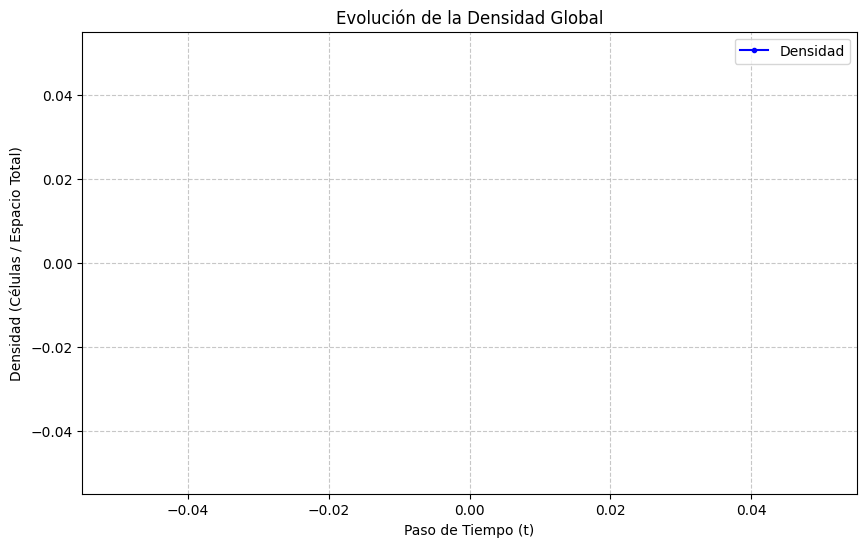

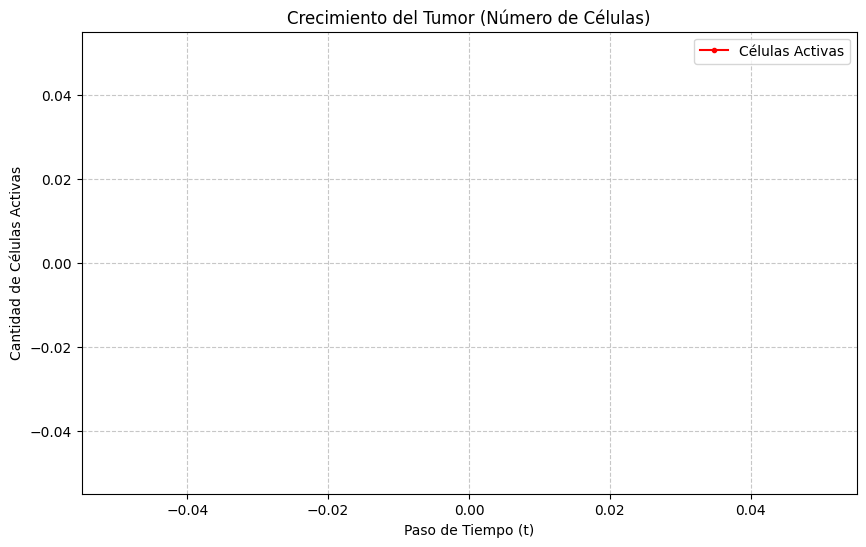

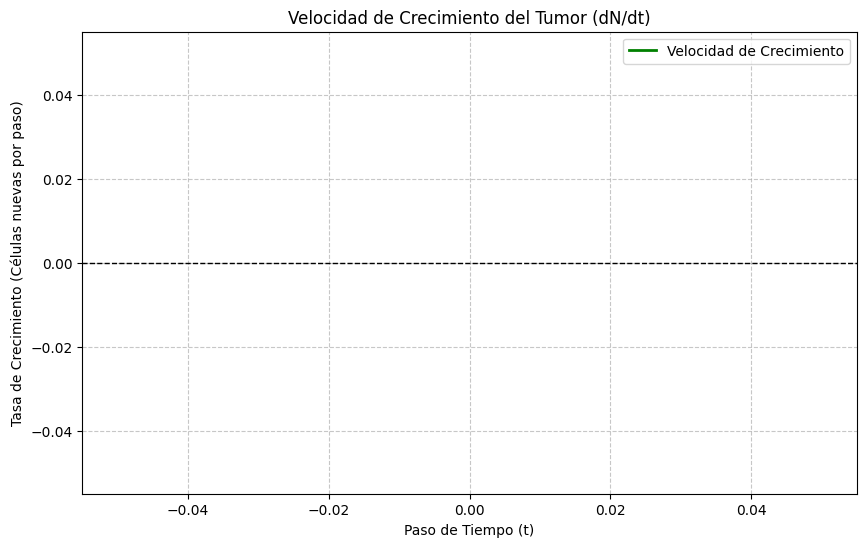

In [3]:
# ... (Después de calcular 'growth_rate_list' y 'time_steps_for_derivative') ...

# ==========================================
# GRÁFICA 1: Densidad Global vs. Tiempo
# ==========================================
plt.figure(figsize=(10, 6))
plt.plot(time_step_list, densidad_global, color='blue', linestyle='-', marker='o', markersize=3, label='Densidad')
plt.title("Evolución de la Densidad Global")
plt.xlabel("Paso de Tiempo (t)")
plt.ylabel("Densidad (Células / Espacio Total)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# ==========================================
# GRÁFICA 2: Conteo de Células vs. Tiempo
# ==========================================
plt.figure(figsize=(10, 6))
plt.plot(time_step_list, celulas_activas, color='red', linestyle='-', marker='o', markersize=3, label='Células Activas')
plt.title("Crecimiento del Tumor (Número de Células)")
plt.xlabel("Paso de Tiempo (t)")
plt.ylabel("Cantidad de Células Activas")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# ==========================================
# GRÁFICA 3: Tasa de Crecimiento (Derivada)
# ==========================================
plt.figure(figsize=(10, 6))

# AQUÍ ESTÁ EL CAMBIO: Sin 'marker', solo línea sólida ('-')
plt.plot(time_step_list[1:], growth_rates, color='green', linestyle='-', linewidth=2, label='Velocidad de Crecimiento')

plt.title("Velocidad de Crecimiento del Tumor (dN/dt)")
plt.xlabel("Paso de Tiempo (t)")
plt.ylabel("Tasa de Crecimiento (Células nuevas por paso)")

# Añadimos una línea horizontal en 0 para referencia visual
plt.axhline(0, color='black', linewidth=1, linestyle='--') 

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


                    